In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
from datacube import helpers

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [3]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [4]:
""" 
square 60 -149  'lat': (-33.107410, -33.216838),
near parkes      'lon': (148.264306, 148.470191),

big parkes square 60 -149  
        'lat': (-33.0401, -33.2450),
        'lon': (148.2176, 148.5140),

canberra east 62_-159
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),

square 60_-155, Barwang
        'lat': (-34.382385, -34.577689),
        'lon': (148.425899, 148.734517),
        
Lake Wombah 49 -129
        'lat': (-28.85916, -29.11364),
        'lon': (144.73454, 145.023037),

"""

" \nsquare 60 -149  'lat': (-33.107410, -33.216838),\nnear parkes      'lon': (148.264306, 148.470191),\n\nbig parkes square 60 -149  \n        'lat': (-33.0401, -33.2450),\n        'lon': (148.2176, 148.5140),\n\ncanberra east 62_-159\n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),\n\nsquare 60_-155, Barwang\n        'lat': (-34.382385, -34.577689),\n        'lon': (148.425899, 148.734517),\n        \nLake Wombah 49 -129\n        'lat': (-28.85916, -29.11364),\n        'lon': (144.73454, 145.023037),\n\n"

In [5]:
#load sentinal data
sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['blue', 'green', 'red'#,
             #'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 
            ,'pixel_quality'
              ] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-33.107410, -33.216838),
        'lon': (148.264306, 148.470191),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-06-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

#data_sent = data_sent.where(clear_pixels)


In [6]:
"""#generate sentinal geomedian?
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)"""

"#generate sentinal geomedian?\n#cast the data to float numbers so geomedian calculation will work\ndata_sent_flt = data_sent.astype(float,casting='safe')\n\n#create geomedian for data\nSentinal_gm=GeoMedian().compute(data_sent_flt)"

In [13]:
Sentinal_time = data_sent.isel(time=0)
Sentinal_time

<xarray.Dataset>
Dimensions:        (x: 2049, y: 1457)
Coordinates:
    time           datetime64[ns] 2016-01-14T00:19:02.528000
  * y              (y) float64 -3.707e+06 -3.707e+06 -3.707e+06 -3.707e+06 ...
  * x              (x) float64 1.502e+06 1.502e+06 1.502e+06 1.502e+06 ...
Data variables:
    blue           (y, x) int16 940 900 901 959 1050 1013 958 929 937 911 ...
    green          (y, x) int16 1134 1053 1134 1167 1181 1153 1089 1097 1106 ...
    red            (y, x) int16 1412 1299 1309 1365 1444 1422 1418 1398 1414 ...
    pixel_quality  (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:3577

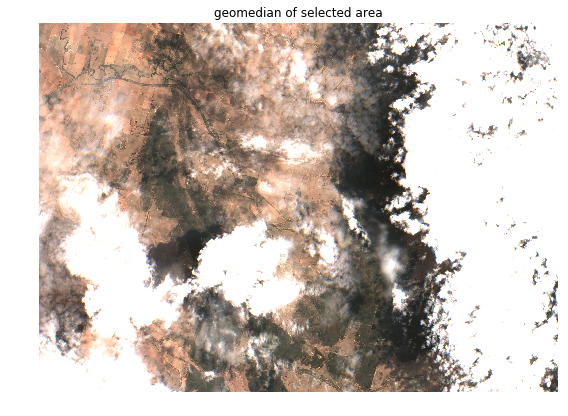

In [60]:
#plot RGB image
#Prepare geomedian imagery for plotting

rgb = Sentinal_time.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [61]:
Sentinal_time = data_sent.isel(time=0)
Sentinal_time

<xarray.Dataset>
Dimensions:        (x: 2049, y: 1457)
Coordinates:
    time           datetime64[ns] 2016-01-14T00:19:02.528000
  * y              (y) float64 -3.707e+06 -3.707e+06 -3.707e+06 -3.707e+06 ...
  * x              (x) float64 1.502e+06 1.502e+06 1.502e+06 1.502e+06 ...
Data variables:
    blue           (y, x) int16 940 900 901 959 1050 1013 958 929 937 911 ...
    green          (y, x) int16 1134 1053 1134 1167 1181 1153 1089 1097 1106 ...
    red            (y, x) int16 1412 1299 1309 1365 1444 1422 1418 1398 1414 ...
    pixel_quality  (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:3577

In [62]:
group_smad_green = {}
band_list = [1,2,3]

In [63]:
#load smad/green product for area
for band in band_list:#49 -129

    data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_60_-149.tif', data_sent.geobox, num_bands=(1,2,3), X_band=band)
    group_smad_green[band] = data

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [68]:
data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
#ori_n,ori_y,ori_x=data_smad_green.shape
#data_smad_green[0]
data_smad_green = data_smad_green.to_dataset(dim='band')
data_smad_green_bigger = data_smad_green*100

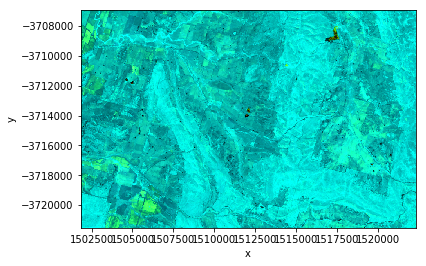

In [69]:
three_band = data_smad_green[[0,1,2]].to_array()
three_band.plot.imshow(robust=True)

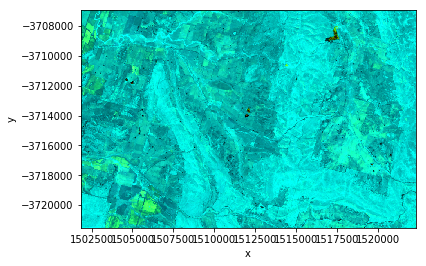

In [70]:
three_band = data_smad_green_bigger[[0,1,2]].to_array()
three_band.plot.imshow(robust=True)

In [73]:
print(np.amin(data_smad_green_bigger[1]))

<xarray.DataArray 1 ()>
array(-33.085007)


In [61]:
urban_bare_1 = (np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.2)).astype('int16')
urban_bare_2 = np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.36)
urban_bare_2 = urban_bare_2.astype('int16')

In [50]:
urban_bare_1

<xarray.DataArray (y: 2622, x: 3017)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y        (y) float64 -3.699e+06 -3.699e+06 -3.699e+06 -3.699e+06 ...
  * x        (x) float64 1.497e+06 1.497e+06 1.497e+06 1.497e+06 1.497e+06 ...

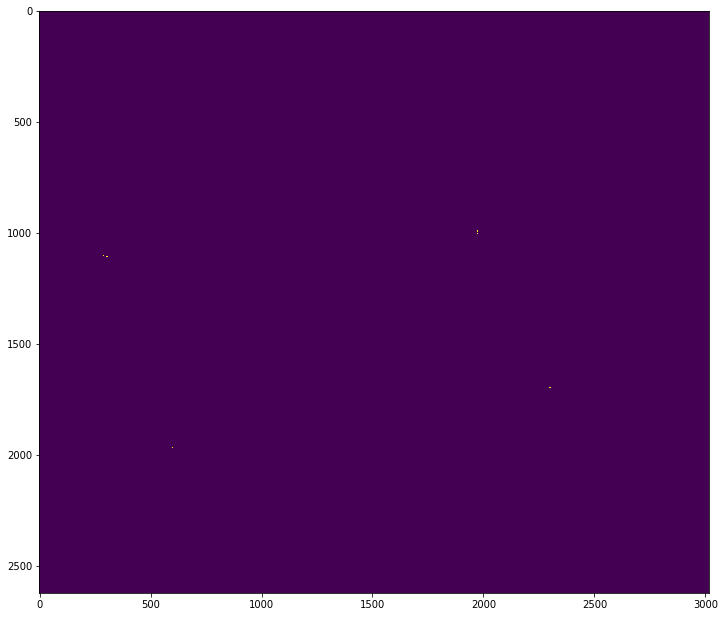

In [51]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(urban_bare_1)

plt.show()

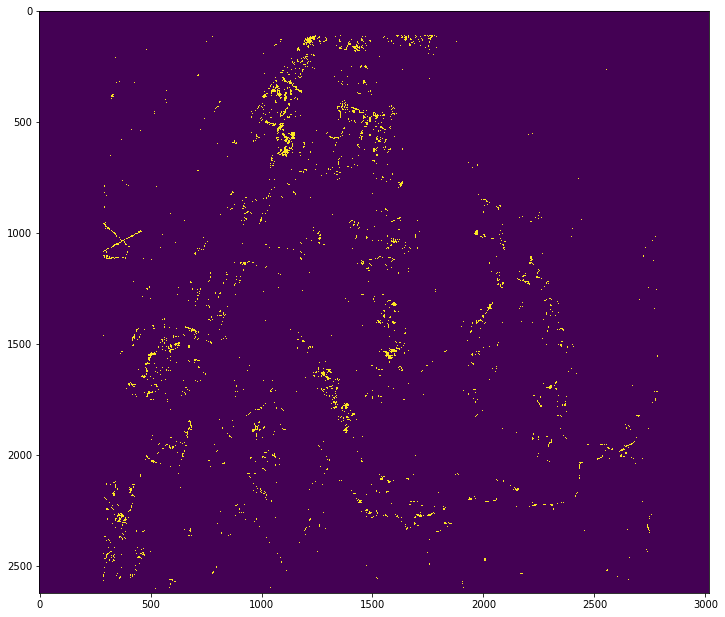

In [62]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(urban_bare_2)

plt.show()

In [59]:
#add classification results to dataset
##replace with Geomediam 
Sentinal_time["urbare"] = urban_bare_2
Sentinal_time
#add smad/green to dataset?

<xarray.Dataset>
Dimensions:  (x: 3017, y: 2622)
Coordinates:
    time     datetime64[ns] 2016-01-14T00:19:02.528000
  * y        (y) float64 -3.699e+06 -3.699e+06 -3.699e+06 -3.699e+06 ...
  * x        (x) float64 1.497e+06 1.497e+06 1.497e+06 1.497e+06 1.497e+06 ...
Data variables:
    blue     (y, x) int16 1063 1052 1026 1048 1103 1112 1050 991 994 1059 ...
    green    (y, x) int16 1234 1230 1208 1180 1193 1164 1168 1116 1079 1098 ...
    red      (y, x) int16 1578 1532 1564 1527 1457 1420 1382 1299 1229 1312 ...
    urbare   (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

In [60]:
#save dataset as netCDF to look at in QGIS
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/parks_bare_2.tif',Sentinal_time)

In [38]:
test_one = np.array([True,False,True,False,False,False])
test_two = np.array([False,False,False,True,False,True])

In [39]:
test_one=test_one * 1
test_two=test_two * 2
master_test = test_one + test_two
master_test

array([1, 0, 1, 2, 0, 2])